In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [41]:
local_stringdb = 'D:/study/thesis/project/HBDM-main/data/nn_data/stringdb/'
# load local STRING database and names
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()
df = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
df['alias'] = df['alias'].str.upper()
aliases2stringId = df.set_index('alias')['#string_protein_id'].to_dict()

#string_score_transform = lambda x: -np.log(x/1000)

graph_df = pd.read_csv(local_stringdb+'9606.protein.physical.links.detailed.v12.0.txt', sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
#network['combined_score'] = network['combined_score'].apply(string_score_transform)
graph_df = graph_df[['protein1', 'protein2','combined_score']]
proteins = sorted(list(set(graph_df['protein1'].tolist())|set(graph_df['protein2'].tolist())))
gene2node = {value: index for index, value in enumerate(proteins)}
graph_df['node1']=graph_df['protein1'].map(gene2node)
graph_df['node2']=graph_df['protein2'].map(gene2node)
graph_df['combined_score'] = graph_df['combined_score']*0.001
PPI_G = nx.from_pandas_edgelist(graph_df, source='node1', target='node2', edge_attr='combined_score', create_using=nx.Graph)
graph_df['combined_score'] = round(graph_df['combined_score'],1)
int_G = nx.from_pandas_edgelist(graph_df, source='protein1', target='protein2', edge_attr='combined_score', create_using=nx.Graph)



In [42]:
import scipy.sparse as sp
file_path_d = r'D:\study\thesis\project\HBDM-main\data\sc_vsmc_hv\sc_sub.p'
with open(file_path_d, 'rb') as file:
    sc_sub = pickle.load(file)

gene_pair = sc_sub.adjacency
gene_pair = gene_pair.round(2)
st_idx = gene_pair.columns.to_numpy()
st_arr = gene_pair.to_numpy()
 
 
del sc_sub
 
# create sparse matrix from st_arr_new
sparse_matrix = sp.csr_matrix(st_arr)
 
# get upper triangle as a sparse array
sparse_upper = sp.triu(sparse_matrix, k=1)
i, j, data = sp.find(sparse_upper)
 
col1 = st_idx[i]
col2 = st_idx[j]
graph_df = pd.DataFrame({'combined_score': data})
graph_df['protein1'] = col1
graph_df['protein2'] = col2
print(len(graph_df))
graph_df = graph_df[graph_df['combined_score'] != 0]
print(len(graph_df))
proteins = sorted(list(set(graph_df['protein1'].tolist())|set(graph_df['protein2'].tolist())))
gene2node = {value: index for index, value in enumerate(proteins)}
 
graph_df['node1']=graph_df['protein1'].map(gene2node)
graph_df['node2']=graph_df['protein2'].map(gene2node)
 
sc_G = nx.from_pandas_edgelist(graph_df, source='node1', target='node2', edge_attr='combined_score', create_using=nx.Graph)

1001047
1001047


In [43]:
graph_df['combined_score'] = round(graph_df['combined_score'],1)
scint_G = nx.from_pandas_edgelist(graph_df, source='protein1', target='protein2', edge_attr='combined_score', create_using=nx.Graph)

In [16]:

def plot_degree_distribution(name, G, use_weight=False):
    """
    Plot the degree distribution of a graph.

    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation
    """

    # Compute the degree distribution
    if use_weight:
        print('weight')
        degree_sequence = sorted([int(d) for n, d in G.degree(weight="combined_score")], reverse=True)
    else:
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    hist, bins = np.histogram(degree_sequence, bins='auto')

    # Plot the degree distribution on a log-log scale
    plt.loglog(bins[:-1], hist, 'o')
    # plt.title(name+" Degree Distribution")
    plt.xticks(fontsize=12)  # Set the fontsize for x-axis tick labels
    plt.yticks(fontsize=12)
    plt.xlabel("Degree (log scale)", fontsize=14)
    plt.ylabel("Fraction of Nodes (log scale)", fontsize=14)
    plt.show()


def average_degree(G, use_weight):
    """
    Calculate the average degree of a graph.

    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation

    Returns:
    - avg_degree: Average degree of the graph
    """

    # Compute the degree sequence
    if use_weight:
        degree_sequence = [d for n, d in G.degree(weight="combined_score")]
    else:
        degree_sequence = [d for n, d in G.degree()]

    # Calculate the average degree
    avg_degree = sum(degree_sequence) / len(degree_sequence)

    return avg_degree

In [44]:
for network in [PPI_G,int_G,sc_G,scint_G]:
    N = network.number_of_nodes()
    E = network.number_of_edges()
    print(N,E,nx.density(network),np.log(E)/np.log(N))

18767 738805 0.004195592067433907 1.373271140731948
18767 738805 0.004195592067433907 1.373271140731948
5168 1001047 0.07497621246047644 1.6159260232288324
5168 1001047 0.07497621246047644 1.6159260232288324


In [45]:
average_degree(PPI_G, use_weight=False),average_degree(sc_G, use_weight=False)

(78.7344807374647, 387.4020897832817)

In [46]:
average_degree(PPI_G, use_weight=True),average_degree(sc_G, use_weight=True)

(28.390894762082453, 9.08098684210526)

In [47]:
average_degree(int_G, use_weight=True),average_degree(scint_G, use_weight=True)

(28.892939734640297, 3.9409829721362306)

In [49]:
degree_sequence = sorted([int(d) for n, d in scint_G.degree(weight="combined_score")], reverse=True)

In [51]:
len(degree_sequence)

5168

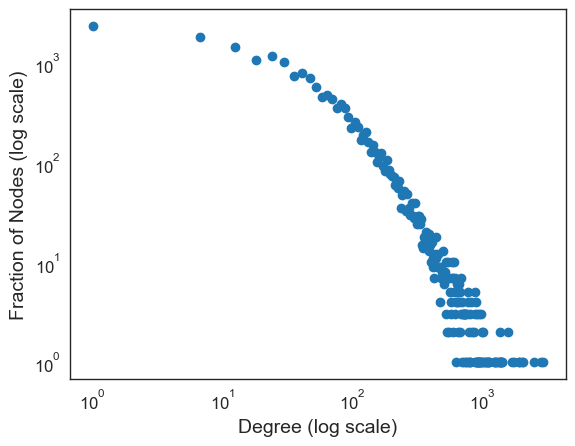

weight


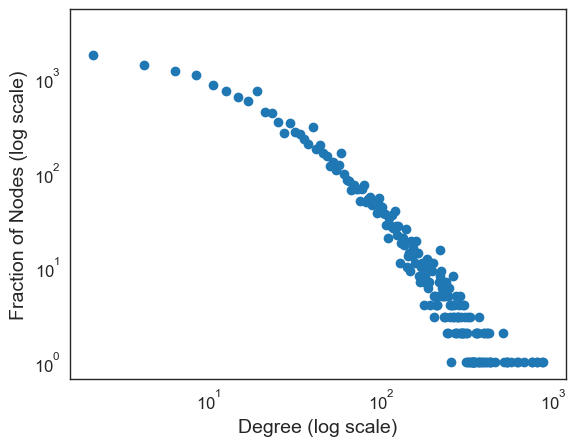

weight


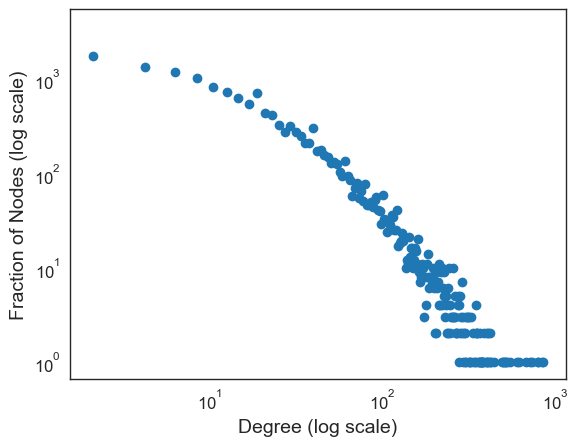

In [52]:
plot_degree_distribution('Continous VSMC co-exp Network',PPI_G, use_weight=False)
plot_degree_distribution('Binary PPI Network',int_G, use_weight=True)
plot_degree_distribution('Binary PPI Network',PPI_G, use_weight=True)

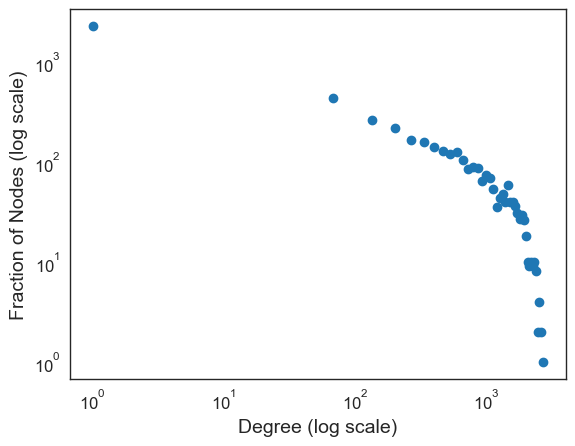

weight


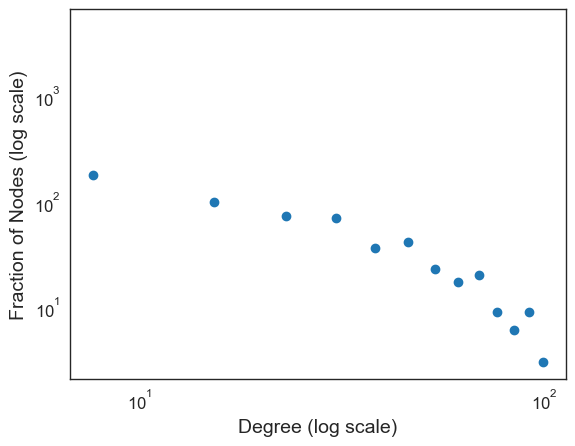

weight


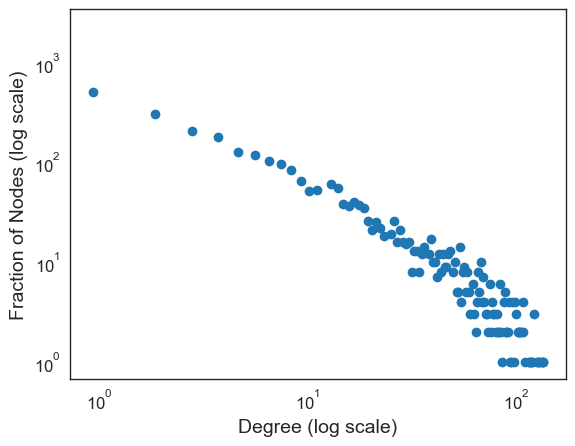

In [48]:
plot_degree_distribution('Continous VSMC co-exp Network',sc_G, use_weight=False)
plot_degree_distribution('Binary PPI Network',scint_G, use_weight=True)
plot_degree_distribution('Binary PPI Network',sc_G, use_weight=True)